In [65]:
import pandas as pd

# Obtains the file and cleans it
FILE_PATH = 'data/Advertising.csv' 
df = pd.read_csv(FILE_PATH).drop('Unnamed: 0', axis=1)

# Obtains our x and y vectors
x = df.TV.to_numpy()
y = df.Sales.to_numpy()

# Displays the dataframe
df

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9
...,...,...,...,...
195,38.2,3.7,13.8,7.6
196,94.2,4.9,8.1,9.7
197,177.0,9.3,6.4,12.8
198,283.6,42.0,66.2,25.5


In [66]:
import torch
import torch.nn as nn

class KL_Divergence(nn.Module):
    def __init__(self, rand_size=100):
        super().__init__()

        # The parameters needed to do divergence
        self.mu_m = nn.Parameter(torch.tensor(1.0), requires_grad=True)
        self.sig_m = nn.Parameter(torch.tensor(1.0), requires_grad=True)
        self.mu_b = nn.Parameter(torch.tensor(1.0), requires_grad=True)
        self.sig_b = nn.Parameter(torch.tensor(1.0), requires_grad=True)
        self.noise = nn.Parameter(torch.tensor(1.0), requires_grad=True)
        
        # The size parameter used for random generation
        self.rand_size = rand_size
        
        # Collect losses over time
        self.losses = []
        
    def forward(self, x: torch.Tensor, y: torch.Tensor):
        m = torch.normal(self.mu_m.item(), self.sig_m.item(), (self.rand_size,))
        b = torch.normal(self.mu_b.item(), self.sig_b.item(), (self.rand_size,))
        
        res = self.log_q(m, b) + self.log_p_given(x, y, m, b) + self.log_p(m) + self.log_p(b)
        
        loss = torch.sum(res)
        self.losses.append(loss.item())
        
        return loss
    
    def log_q(self, m, b):
        res_m = -((m - self.mu_m) ** 2 / (2 * self.sig_m ** 2) + 0.5 * torch.log(self.sig_m ** 2))
        res_b = -((b - self.mu_b) ** 2 / (2 * self.sig_b ** 2) + 0.5 * torch.log(self.sig_b ** 2))
        
        return res_m + res_b
    
    def log_p_given(self, x, y, m, b):        
        return torch.sum(((y - torch.einsum('i,j->ij', m, x)).T - b) ** 2 / (2 * self.noise ** 2) + 0.5 * torch.log(self.noise ** 2), dim=0)
    
    def log_p(self, k):
        return k ** 2 / 2

In [67]:
import torch.optim as optim
from tqdm import tqdm

# Trains the specific model
def kl_train(x, y, rand_size=100, model=None, epochs=5, frac=0.1):
    if model == None:
        model = KL_Divergence(rand_size=100)
    optimizer = optim.Adam(model.parameters())
    
    for epoch in tqdm(range(epochs), desc="Training..."):
        # Zeros gradiant for training
        optimizer.zero_grad()
        
        # Random selection of data points per iteration
        indices = torch.randint(low=0, high=110, size=(int(len(x) * 0.1), 1))
        
        # Calculates likelihood
        loglik = model(torch.tensor(x[indices]).flatten(), torch.tensor(y[indices]).flatten())
        #loglik = model(x, y)
        
        # Mean of loglik
        e = -torch.mean(loglik)
        
        # Updates parameters
        e.backward()
        optimizer.step()
        
    return model

In [68]:
model_kl = kl_train(x, y, epochs=1000)

Training...: 100%|██████████| 1000/1000 [00:00<00:00, 1370.93it/s]


In [69]:
model_kl.mu_m, model_kl.sig_m, model_kl.mu_b, model_kl.sig_b, model_kl.noise

(Parameter containing:
 tensor(0.9660, requires_grad=True),
 Parameter containing:
 tensor(1.0130, requires_grad=True),
 Parameter containing:
 tensor(1.0099, requires_grad=True),
 Parameter containing:
 tensor(0.9994, requires_grad=True),
 Parameter containing:
 tensor(-0.0127, requires_grad=True))

[Text(0.5, 0, 'Epoch'),
 Text(0, 0.5, 'Loss'),
 Text(0.5, 1.0, 'Likelihood Loss')]

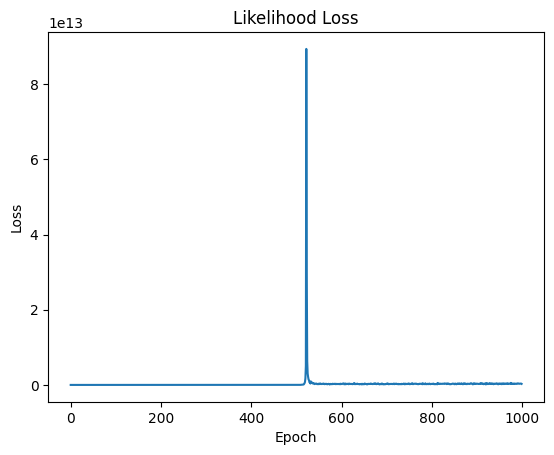

In [71]:
import seaborn as sns

fig = sns.lineplot(x=range(len(model_kl.losses)), y=model_kl.losses)
fig.set(xlabel='Epoch', ylabel='Loss', title='Likelihood Loss')

Training...: 100%|██████████| 300/300 [00:00<00:00, 1381.23it/s]


[Text(0.5, 0, 'Epoch'),
 Text(0, 0.5, 'Loss'),
 Text(0.5, 1.0, 'Likelihood Loss')]

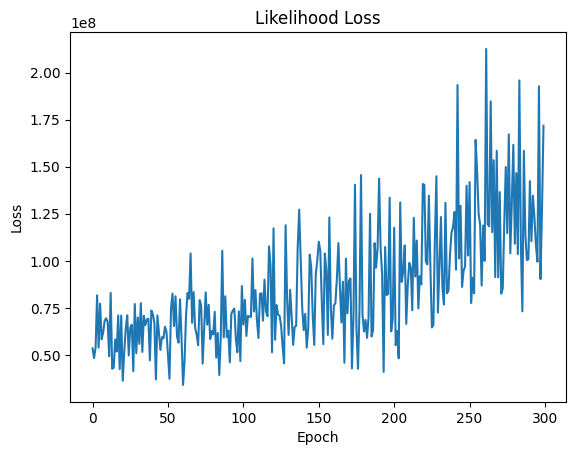

In [72]:
model_kl_2 = kl_train(x, y, epochs=300)

fig = sns.lineplot(x=range(len(model_kl_2.losses)), y=model_kl_2.losses)
fig.set(xlabel='Epoch', ylabel='Loss', title='Likelihood Loss')